<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Gaussian Process Kernels<br>for Pattern Discovery and Extrapolation</div><br>

The aim of this notebook is to explore the use of more exotic kernels in Gaussian Process (GP), compared to the squared exponentiel (SE) kernel for instance. More precisely, it will focus on spectral mixture (SM) kernel. This notebook is largely inspired by the article [*Gaussian Process Kernels for Pattern Discovery and Extrapolation*](http://proceedings.mlr.press/v28/wilson13.pdf) written by Andrew G. Wilson, Ryan P. Adams.

In order to do so, you will find in this notebook these different parts:

1. [Introduction](#sec1)
2. [A quick reminder on Gaussian Processes](#sec2)
3. [Theoritical elements on the spectral mixture kernels](#sec3)
4. [Use-case of SM kernel for airline passengers data](#sec4)
5. [Comparaison between SM kernel and a composition of kernels on CO2 concentration at Mauna Loa](#sec5)
6. [Conclusion](#sec6)

Finaly, to run this notebook you will need to import this parckage from my git repository. To do so, just run the next cell.

In [13]:
#pip install git+https://github.com/Corentin-LF/pyGPs.git#egg=pyGPs

In [8]:
#Faire une arrivée plus smooth pour les rappels des GP ?
#Parler de la covariance négative ?

In [14]:
#Rechercher d'autres articles connexes pour la partie 3

# 1. <a id="sec1"></a>Introduction

Machine learning is fundamentally about pattern discovery. The first machine learning models, such as the perceptron (Rosenblatt, 1962), were based on a simple model of a neuron (McCulloch & Pitts, 1943).

Research on Gaussian processes (GPs) within the machine learning community developed out of neural networks research, triggered by Neal (1996), who observed that Bayesian neural networks became Gaussian processes as the number of hidden units approached infinity.

The properties of likely functions under a Gaussian Process, e.g. smoothness, periodicity, etc,.. are controlled by a positive definite covariance kernel, which is an operator determining the similarity between pairs of points in the domain of the random function. Therefore the choice of kernel deeply affects the result of a Gaussian process on a given task.

Gaussian processes are sometimes used as expressive statistical tools, where the pattern discovery is performed by a human, and then hard coded into parametric kernels. Often, however, the squared exponential (Gaussian) kernel is used by default. In either case, GPs are used as smoothing interpolators with a fixed (albeit infinite) set of basis functions. Such simple smoothing devices are not a realistic replacement for neural networks, which were envisaged as intelligent agents that could discover hidden features in data via adaptive basis functions (MacKay, 1998).

With more expressive kernels, one could use Gaussian processes to learn hidden representations in data. Expressive kernels have been developed by combining Gaussian processes in a type of Bayesian neural net- work structure (Salakhutdinov & Hinton, 2008; Wilson et al., 2012; Damianou & Lawrence, 2012). However, these approaches, while promising, typically:

1 - Are designed to model specific types of structure (e.g., input-dependent correlations between different tasks)<br>
2 - Make use of component GPs with simple interpolating kernels<br>
3 - Indirectly induce complicated kernels that do not have a closed form and are difficult to interpret<br>
4 - Require sophisticated approximate inference techniques that are much more demanding than that required by simple analytic kernels.<br>

Moreover, while some compositions (e.g., addition) have an interpretable effect, many other operations change the distribution over functions in ways that are difficult to identify. Therefore, **it is difficult, to construct an effective inductive bias for kernel composition that leads to automatic discovery of the appropriate statistical structure,** without human intervention. Finaly, **complicated compositions of kernels can lead to overfitting and unmanageable hyperparameter inference.** 

That is whay, in the article *Gaussian Process Kernels for Pattern Discovery and Extrapolation*, Andrew G. Wilson and Ryan P. Adams propose new kernels which can be used to automatically discover patterns and extrapolate far beyond the available data. This class of kernels contains many stationary kernels, but has a simple closed form that leads to **straightforward analytic inference**. The simplicity of these kernels is one of their strongest qualities. In many cases, these kernels can be used as a **drop in replacement** for the popular squared exponential kernel, with benefits in performance and expressiveness.

# 2. <a id="sec2"></a>A quick reminder on Gaussian Processes


Now you get an idea what you are going throw, yo will find the following section a reminder on Gaussian Processes mainly based on the article *Gaussian Process Kernels for Pattern Discovery and Extrapolation* written by Andrew G. Wilson, Ryan P. Adams. You may also find with more details in the [Machine Learning class](https://github.com/erachelson/MLclass) by [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en).

A Gaussian process is a collection of random variables, any finite number of which have a joint Gaussian distribution. Using a Gaussian process, we can define a distribution over functions $f(x)$,

$$f(x) \sim \mathcal{G}\mathcal{P}(m(x),k(x,x'))$$

Where $x$ ∈ $\mathbb{R}^p$ is an arbitrary input variable, and the mean function $m(x)$ and covariance kernel $k(x, x′)$ are defined as:

$$m(x) = \mathbb{E}[f(x)]$$
$$k(x, x') = cov(f(x), f(x'))$$

So any collection of function values has a joint Gaussian distribution

$$[f(x_1),f(x_2),...,f(x_N)]^{T} \sim \mathcal{P}(\mu,K)$$

Where:
* $K$ is the $N$x$N$ covariance matrix with the entries $K_{ij}=k(x_i,x_j)$
* $\mu$ is the mean with the entries $\mu_i=m(x_i)$

As said in the introduction, the choice of kernel deeply affects the performance of a Gaussian process on a given task, as much as the choice of architecture, activation functions, ... for neural networks.

A popular kernel is the squared exponential (SE) kernel:

$$k_{SE}(x,x') = \sigma^2 e^{-\frac{(x-x')^2}{2 l^2}}$$

With this kernel, Gaussian processes are infinitely differentiable, and there are able to display long range trends. GPs with a squared exponential kernel are simply smoothing devices: the only covariance structure that can be learned from data is the length-scale l, which determines how quickly a Gaussian process function varies with x.

But then, what happend if we try to use this kernel on data which also have cyclic variations ?
Let's try to implement it on Airline Passenger Data !

This set of data represents the airline passenger numbers, recorded monthly, from 1949 to 1961. Run the cell below to have a look.

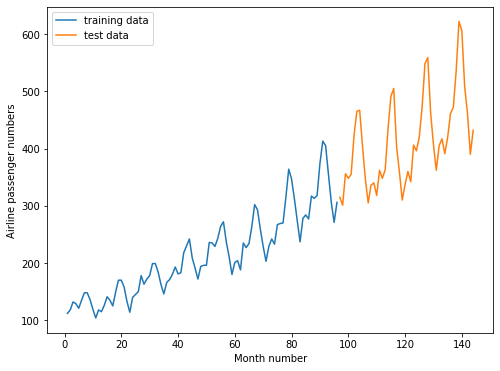

In [1]:
from scipy import io as sio
import numpy as np
import matplotlib.pyplot as plt

#Data importation
data = sio.loadmat('airlinedata.mat')

X = np.atleast_2d(data['xtrain'])
y = np.atleast_2d(data['ytrain'])
xt = np.atleast_2d(data['xtest'])
yt = np.atleast_2d(data['ytest'])

#Plot
plt.figure(figsize=(8,6))
plt.plot(X,y, label = 'training data')
plt.plot(xt,yt, label = 'test data')
plt.xlabel('Month number')
plt.ylabel('Airline passenger numbers')
plt.legend(loc="best")
plt.show()

Now, let's train a first GP with a SE kernel in order to predict the test data.

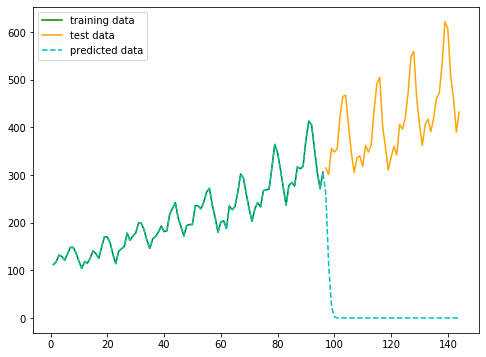

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


#GP training
gp_kernel=RBF() #RBF is the scikit-learn implementation of the SE kernel
gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

#GP prediction
X_plot = np.concatenate((X,xt),axis=0)
y_gpr, y_std= gpr.predict(X_plot, return_std=True)

# Plot
plt.figure(figsize=(8,6))
plt.plot(X,y,'g',label='training data')
plt.plot(xt,yt,'orange', label='test data')
plt.plot(X_plot,y_gpr, 'c--', label='predicted data')
plt.legend(loc="best")
plt.show()

As shown in the article, the SE kernel does not seems accurate to predict the evolution in the airline passenger numbers.

We can also try to solve this problem with more developed kernels, such as the ExpSinSquared kernels. If you want more details, you will find the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ExpSineSquared.html).

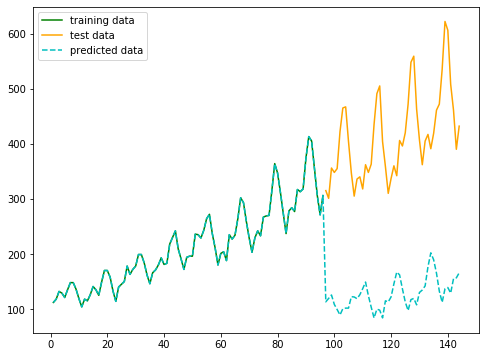

In [4]:
from sklearn.gaussian_process.kernels import ExpSineSquared

# GP training
gp_kernel = ExpSineSquared()
gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

# GP prediction
X_plot = np.concatenate((X,xt),axis=0)
y_gpr, y_std= gpr.predict(X_plot, return_std=True)

# Plot
plt.figure(figsize=(8,6))
plt.plot(X,y,'g',label='training data')
plt.plot(xt,yt,'orange', label='test data')
plt.plot(X_plot,y_gpr, 'c--', label='predicted data')
plt.legend(loc="best")
plt.show()

Once again, the prediction does not fit. Even with fine hyperparameters' tuning, it might not be accurate. So a first solution could be the use of complicated compositions of kernels. But it would lead to overfiting and unmanageable hyperparameter inference. Hence, the development of a new type of kernels, which could be easy to use.

# 3. <a id="sec3"></a>Theoritical elements on the spectral mixture kernels


As we saw with the SE kernel, the prediction of the Gaussian Process is strongly related to the kernel's equation. For this one, the correlation between $y$ and $y'$ is high when $x$ and $x'$ are close. As $x$ and $x'$ get further from each other, $y$ and $y'$ tend to become independent.

In your mind, what kind of *transformation* can be done in order to catch a periodic pattern in a fonction ?<br><br>

We will make a *Fourier Transform* in order to do so !

Just like it is done in Signal processing, we will us the Fourier dual to catch the information we are interested in. (in fact it *is not* a exact *Fourier Transform*, but it is quite the same. )



More precisely the article introduces the class of stationary kernels, in order to use *Bochner's theorem* and nearly make a *Fourier transform*.

A *stationary kernel* is function of $\tau = x - x'$, i.e, which is unvariant to translation of the inputs. Moreover, any stationary kernel can be expressed as an integral using Bochner's theorem.

**The Bochner's theorem is :** *A complex-valued function k on $\mathbb{R}^P$ is the covariance function of a weakly stationary mean sqaure continious complexe-valued random process on $\mathbb{R}^P$ if and only if it can be represented as*

$$k(\tau)= \displaystyle \int_{\mathbb{R}^P}^{} e^{2\pi i s^{T} \tau} \psi(ds) $$

*where $\psi$ is a positive finite measure.*


If $\psi$ has a density $S(s)$, then $S$ is called the *spectral density* or *power spectrum* of $k$, and $k$ and $S$ are Fourier duals:

$$k(\tau)= \displaystyle \int_{\mathbb{R}^P}^{} S(s)e^{2\pi i s^{T} \tau} ds$$

$$S(s)= \displaystyle \int_{\mathbb{R}^P}^{} k(\tau)e^{-2\pi i s^{T} \tau} d\tau $$

**In other words, a spectral density entirely determines the properties of a stationary kernel.**

We could apply this to the squared exponential kernel, but it would be a very small corner of the set of possible stationary kernels, as they correspond only to Gaussian spectral densities centered on the origin. To have a bigger scope, we will use a *mixture of Gaussians* that have non-zero means, one can achieve a much wider range of spectral densities.

Lets consider the following fonction:

$$\phi(s;\mu,\sigma^{2}) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2\sigma^2}(s-\mu)^2}$$

$$S(s) = [\phi(s) + \phi(-s)]/2$$

Noting that spectral densities are symmetric. Substituting $S(s)$ into equation of $k(\tau)$, we find:

$$k(\tau) = e^{-2\pi^2\tau^2\sigma^2}cos(2\pi\tau\mu)$$

If $\phi(s)$ is instead a mixture of Q Gaussians
on $\mathbb{R}^P$ , where the $q^th$ component has mean vector $\mu_q = (\mu_q^{1},...,mu_q^{P})$ and covariance matrix $M_q = diag(v_q^{1} ,...,v_q^{P})$, and $\tau_p$ is the $p^{th}$ component of the P dimensional vector $\tau = x − x'$, then

$$k(\tau) = \sum_{q=1}^{Q}w_q\prod_{p=1}^{P}e^{-2\pi^2\tau_p^2v_q^{(p)}}cos(2\pi\tau_p\mu_q^{(p)})$$

The integral in $k(\tau)$ is tractable even when the spectral density is an arbitrary Gaussian mixture, allowing us to derive the exact closed form expressions in the last two equations, and to perform analytic inference with Gaussian processes. 

<div class="alert alert-success"> 

Thus, we get kernels easy to interpret, and provide drop-in replacements for kernels. With:
* The weights $w_q$ specify the relative contribution of each mixture component.
* The inverse means $\frac{1}{\mu_q}$ are the component periods.
* The inverse standard deviations $\frac{1}{\sqrt(v_q)}$ are length-scales, determining how quickly a component varies with the inputs x.
* $k(\tau) = \sum_{q=1}^{Q}w_q\prod_{p=1}^{P}e^{-2\pi^2\tau_p^2v_q^{(p)}}cos(2\pi\tau_p\mu_q^{(p)})$ will be the kernel we refer to as a spectral mixture (SM) kernel.

In [6]:
#The kernel in Eq. (12) can also be interpreted through its associated spectral density
#A dire ou non ?

In [7]:
#Implementation du kernel ?

# 4. <a id="sec4"></a>Use-case of SM kernel for airline passengers data

First, import the package pyGPs I modified directly from my git repository if you haven't done it at the beginning. Use the following line command:

In [8]:
#pip install -e git+https://github.com/Corentin-LF/pyGPs.git#egg=pyGPs

In the cells bellow, you will run the implementation of a SM kernel from pyGPs I modified. Just run it and have a look at the result. It might be a bit long to run.

In [2]:
import pyGPs
from sklearn.metrics import mean_squared_error

Number of line searches 1000


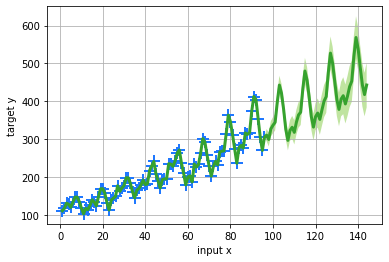

In [18]:
# Set the number of Gaussian you want to use
Q = 10

model = pyGPs.GPR()           # start from a new model

# Specify non-default mean and covariance functions
# @SEE doc_kernel_mean for documentation of all kernels/means
m = pyGPs.mean.Zero()


k = pyGPs.cov.SM(Q)
k.initSMhypers(X, y)
model.setPrior(kernel=k)

# Noise std. deviation
sn = 0.1

model.setNoise(log_sigma=np.log(sn))

model.optimize(X, y)
model.predict(X_plot)
model.plot()

Congrats, you just ran your first Gaussian process with a spectral mixture kernel !

Well, maybe it does not looks that great for you. Indeed, for one run out of five the prediction is not accurate.

After quite a long research, I found that the issue was coming from the implementation of the *optimize* fonction. Indeed, it is not able to perfectly train the Kernel's hyperparameters using nonlinear conjugate gradients to optimize the marginal likelihood $p(y|\theta,\{x_n\}_{n=1}^N)$ of the data y given hyperparameters $\theta$. A solution is to increase the number of line searches, but first the computation time will increase and I think you don't want to wait 10 minutes for each run, secondly there are still very few possibilities it does not fit well the the test data.

Unfurtunatly, I did not had to time to also improve this function and to fix this.

So if the result does not look great for you, just run again the cell and it should be fine.

# 5. <a id="sec5"></a>Comparaison to a composition of kernels

As each type of kernel has the ability to capture information in the data, an alternative to the SM kernels would be a composition of more *classical* kernels such as [Radial-basis function (RBF) kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html) or [Rational Quadratic (RQ )kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RationalQuadratic.html).

Just run the cells bellow, feel free to change the parameters of the kernels to see how it changes the result!

In [3]:
from past.utils import old_div

Original CO2 Data:


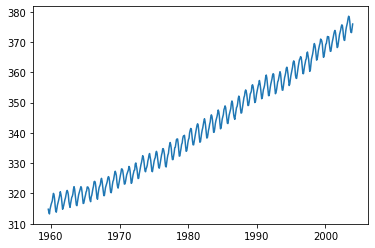

In [4]:
# LOAD data
infile = 'mauna.txt'    # Note: Samples with value -99.99 were dropped.
f      = open(infile,'r')
year   = []
co2    = []
for line in f:
    z  = line.split('  ')
    z1 = z[1].split('\n')
    if float(z1[0]) != -99.99:
        year.append(float(z[0]))
        co2.append(float(z1[0]))
X  = [i for (i,j) in zip(year,co2) if i < 2004]
y  = [j for (i,j) in zip(year,co2) if i < 2004]
xx = [i for (i,j) in zip(year,co2) if i >= 2004]
yy = [j for (i,j) in zip(year,co2) if i >= 2004]

x = np.array(X)
y = np.array(y)
x = x.reshape((len(x),1))
y = y.reshape((len(y),1))
n,D = x.shape

# TEST POINTS
xs = np.arange(2004+old_div(1.,24.),2024-old_div(1.,24.),old_div(1.,12.))
xs = xs.reshape(len(xs),1)

#Plot
print('Original CO2 Data:')
plt.plot(x,y)
plt.show()

In the next cell, you will find the definition of the kernel. The one used here is a composition of 4 different kernels!
Feel free to change their parameters to see how it impacts the result.

Number of line searches 40


Using Handcrafted Kernel from GPML Book:
Time to optimize =  71.693876
Optimized mean =  [342.14969299451695]
Optimized covariance =  [4.2007849460023365, 4.190563170415894, 0.644913802526403, -0.00032855510180444493, 0.6727167979955204, 4.6127228826784625, 0.6727167979955204, 0.14678205715625384, -0.3553935688912192, -0.25048409574862635, -2.0309746132012125, -1.7347744723586367, -1.823611146630937]
Optimized liklihood =  [-2.3258266027287076]
Final negative log marginal likelihood =  107.811


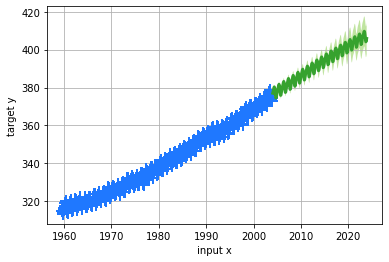

In [7]:
# DEFINE parameterized covariance function
k1 = pyGPs.cov.RBF(np.log(67.), np.log(66.))
k2 = pyGPs.cov.Periodic(np.log(1.3), np.log(1.0), np.log(2.4)) * pyGPs.cov.RBF(np.log(90.), np.log(2.4))
k3 = pyGPs.cov.RQ(np.log(1.2), np.log(0.66), np.log(0.78))
k4 = pyGPs.cov.RBF(np.log(old_div(1.6,12.)), np.log(0.18)) + pyGPs.cov.Noise(np.log(0.19))
k  = k1 + k2 + k3 + k4

# STANDARD GP (prediction)
model = pyGPs.GPR()
model.setData(x,y)
model.setPrior(kernel=k)
model.predict(xs)

# STANDARD GP (training)
model.optimize40(x,y)
model.predict(xs)

print('Using Handcrafted Kernel from GPML Book:')
print('Optimized mean = ', model.meanfunc.hyp)
print('Optimized covariance = ', model.covfunc.hyp)
print('Optimized liklihood = ', model.likfunc.hyp)
print('Final negative log marginal likelihood = ', round(model.nlZ,3))

model.plot()

Now you can train a GP with a SM kernel on this dataset. Just do it in the cell bellow.

In [10]:
#Write your code here if you want !

Or just run the cell below with everything implemented.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  from ipykernel import kernelapp as app
Number of line searches 2
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


 316287473.94393474


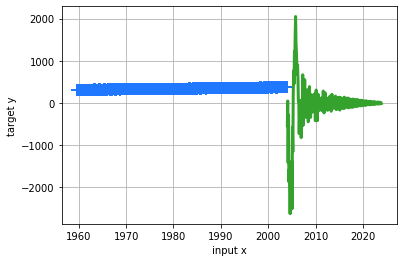

Using Handcrafted Kernel from GPML Book:
Time to optimize =  47.024699
Optimized mean =  []
Optimized covariance =  [0.5837002500401915, 0.5836805666603692, 0.5930246613068257, 0.5836697903364862, 0.5836713188031271, 0.5837350916065024, 0.5836866357487469, 0.5836834665790688, 0.5836812353739756, 0.5836696896840424, 1.5448497257286014, 1.6144653516259921, -0.7313884603518839, 1.6189294765858693, 1.5410790253774802, 0.729337037485552, 1.0019136539653313, 1.7937018325108967, 1.740193650146144, 1.5420640022219119, -2.372984823372879, -2.209056408957914, -2.0427206357392107, -3.4401217365100982, -2.7346297963184525, -2.9996206299738404, -3.7764663870650135, -2.37963671379964, -2.327212276065741, -2.9707231652384203]
Optimized liklihood =  [-2.0231498341762717]
Final negative log marginal likelihood =  316287473.944


In [12]:
# DEFINE parameterized covariance function
Q = 10
k = pyGPs.cov.SM(Q)
k.initSMhypers(x, y)

model = pyGPs.GPR()

model.setPrior(kernel=k)

# Noise std. deviation
sn = 0.1
model.setNoise(log_sigma=np.log(sn))

model.optimize40(x, y)
model.predict(xs)
model.plot()


print('Using Handcrafted Kernel from GPML Book:')
print('Time to optimize = ', t1-t0)
print('Optimized mean = ', model.meanfunc.hyp)
print('Optimized covariance = ', model.covfunc.hyp)
print('Optimized liklihood = ', model.likfunc.hyp)
print('Final negative log marginal likelihood = ', round(model.nlZ,3))

With the composition of kernels, the prediction seems quite accurate, whereas with our implementation of the SM kernel, it is not working. It is even not necessary to compare theis score functions. This is a result of the *optimize* fonction which does not optimize efficiently the marginal likelihood of the data.
That's a really interested point to notice, because it means the SM kernel *is not a fully drop-in solution* for Gaussian Processes.

# 6. <a id="sec6"></a>Conclusion

To conclude, the spectral mixture kernel is a very interested new type of kernels. Indeed, even if its drop-in caracteristic is not perfect, it gives the Gaussian processes a new kernel easy to use, and which can be very powerful in some situation (as seen for the airline passengers data).

Futhermore it can discover patterns in data and extrapolate over long ranges. The simplicity of these ker- nels is one of their strongest properties: they can replacements for popular kernels such as the squared exponential kernel, with major bene- fits in expressiveness and performance, while retaining simple training and inference procedures

References :

* Andrew G. Wilson, Ryan P. Adams, *Gaussian Process Kernels for Pattern Discovery and Extrapolation*, 2014

* Documentation and implementation of the library [pyPGs](https://github.com/marionmari/pyGPs.git) by Marion Neumann, Daniel Marthaler, Shan Huang and Kristian Kersting

* Bochner, Salomon. Lectures on Fourier Integrals.(AM-42), volume 42. Princeton University Press, 1959.

* Rasmussen, Carl Edward and Williams, Christopher K.I. Gaussian processes for Machine Learning. The MIT Press, 2006.

* Rosenblatt, F. Principles of Neurodynamics. Spartan Book, 1962.

* McCulloch, W.S. and Pitts, W. A logical calculus of the ideas immanent in nervous activity. Bulletin of mathematical biology, 5(4):115–133, 1943.

* MacKay, David J.C. Introduction to Gaussian processes. In Christopher M. Bishop, editor (ed.), Neural Networks and Machine Learning, chapter 11, pp. 133–165. Springer-Verlag, 1998.